# AlongTrack Data - SWOT

> In this notebook, we will look at how one can do some simple regridding processes with the AlongTrack SWOT data available from the 2020a OSSE Data Challenge.

In [7]:
import autoroot
import typing as tp
from dataclasses import dataclass
import functools as ft
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [8]:
!ls "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/"

2020a_SSH_mapping_NATL60_envisat.nc
2020a_SSH_mapping_NATL60_geosat2.nc
2020a_SSH_mapping_NATL60_jason1.nc
2020a_SSH_mapping_NATL60_karin_swot.nc
2020a_SSH_mapping_NATL60_nadir_swot.nc
2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc


In [9]:
files_nadir_dc20a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_jason1.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_geosat2.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc",
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_nadir_swot.nc",
]

files_swot_dc20a = [
    "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/raw/dc_obs/2020a_SSH_mapping_NATL60_karin_swot.nc",
    
]

ds_swot = xr.open_dataset(files_swot_dc20a[0])

In [10]:
ds_swot

<xarray.Dataset>
Dimensions:      (nC: 52, time: 188121)
Coordinates:
  * nC           (nC) int64 0 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50 51
  * time         (time) datetime64[ns] 2012-10-02T18:03:42.401288 ... 2013-09...
Data variables: (12/14)
    lon          (nC, time) float64 ...
    lat          (nC, time) float64 ...
    x_al         (nC, time) float32 ...
    x_ac         (nC, time) float32 ...
    lon_nadir    (nC, time) float64 ...
    lat_nadir    (nC, time) float64 ...
    ...           ...
    ssh_obs      (nC, time) float64 ...
    roll_err     (nC, time) float64 ...
    phase_err    (nC, time) float64 ...
    ssh_model    (nC, time) float64 ...
    bd_err       (nC, time) float64 ...
    karin_err    (nC, time) float64 ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [18]:
from oceanbench._src.geoprocessing.validation import validate_latlon, validate_time, decode_cf_time, validate_ssh
from oceanbench._src.preprocessing.alongtrack import alongtrack_ssh
from oceanbench._src.geoprocessing.subset import where_slice
from oceanbench._src.preprocessing.alongtrack import remove_swath_dimension


In [19]:
def preprocess_nadir(da):
    
    # validate coordinates
    da = validate_latlon(da)
    da = validate_time(da)
    
    # validate variables
    da = da.rename({"ssh_model": "ssh"})
    da = validate_ssh(da)
    
    # slice time period
    da = da.sel(time=slice("2012-10-22", "2012-12-03"))
    
    # slice region
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
    
    # reorganized
    da = da.sortby("time")
    
    # assign coordinates
    da = da.set_coords(["time", "lat", "lon"])
    
    return da # da[["ssh"]]

def preprocess_swot(da):
    
    # validate coordinates
    da = validate_latlon(da)
    da = validate_time(da)
    
    # validate variables
    da = da.rename({"ssh_model": "ssh"})
    da = validate_ssh(da)
    
    # slice time period
    da = da.sel(time=slice("2012-10-22", "2012-12-03"))
    
    # remove SWATH dimension
    da = remove_swath_dimension(da, "nC")
    
    # slice region
    da = where_slice(da, "lon", -64.975, -55.007)
    da = where_slice(da, "lat", 33.025, 42.9917)
    
    # reorganized
    da = da.sortby("time")
    
    # assign coordinates
    da = da.set_coords(["time", "lat", "lon"])
    
    return da #da[["ssh"]]


In [20]:
# preprocess_fn = ft.partial(preprocess_nadir_dc20a, variable="ssh_model")

ds_nadir = xr.open_mfdataset(
    files_nadir_dc20a, 
    preprocess=preprocess_nadir,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_nadir = ds_nadir.sortby("time").compute()

ds_nadir

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 139 times more chunks
  return self.array[key]
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 139 times more chunks
  return self.array[key]
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 139 times more chunks
  return self.array[key]
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 139 times more chunks
  return self.array[key]
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray

<xarray.Dataset>
Dimensions:      (time: 42468, cycle: 1)
Coordinates:
    lon          (time) float64 -55.03 -55.06 -55.1 ... -64.89 -64.93 -64.97
    lat          (time) float64 39.58 39.53 39.47 39.42 ... 42.12 42.17 42.22
  * time         (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12...
Dimensions without coordinates: cycle
Data variables:
    x_al         (time) float32 1.008e+06 1.008e+06 ... 5.373e+06 5.373e+06
    ncycle       (time, cycle) timedelta64[ns] 17 days 09:34:50.917929600 ......
    model_index  (time) float32 515.0 515.0 515.0 ... 1.533e+03 1.533e+03
    ssh_obs      (time) float64 0.975 1.008 1.009 ... -0.0774 -0.0679 -0.0703
    ssh          (time) float64 0.9958 1.014 1.027 ... -0.0576 -0.0568 -0.051
    nadir_err    (time) float64 -0.0208 -0.0061 -0.0182 ... -0.0111 -0.0193
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

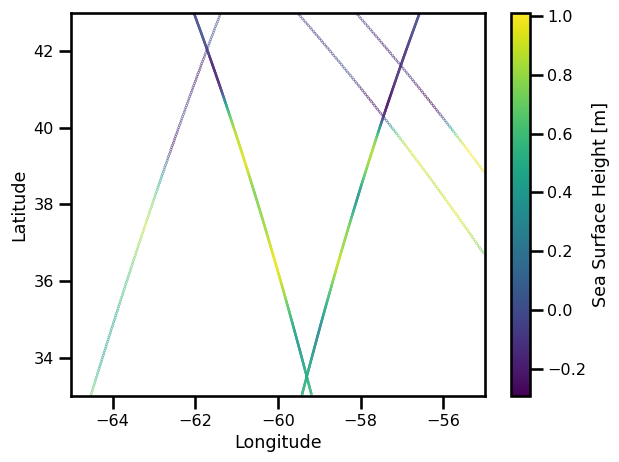

In [21]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_nadir.sel(time=slice("2012-10-26","2012-10-26"))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
    ylim=[33., 43.]
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

In [22]:
%%time

ds_swot = xr.open_mfdataset(
    files_swot_dc20a, 
    preprocess=preprocess_swot,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_swot = ds_swot.sortby("time").compute()

ds_swot

CPU times: user 17.2 s, sys: 4.08 s, total: 21.3 s
Wall time: 18.1 s


<xarray.Dataset>
Dimensions:      (time: 955000)
Coordinates:
    lon          (time) float64 -55.4 -55.37 -55.39 ... -64.45 -64.47 -64.5
    lat          (time) float64 42.99 42.99 42.97 42.97 ... 42.98 42.99 42.99
  * time         (time) datetime64[ns] 2012-10-23T18:04:12.393963 ... 2012-11...
Data variables: (12/13)
    x_al         (time) float32 1.001e+06 1.001e+06 ... 1.01e+07 1.01e+07
    x_ac         (time) float32 -60.0 -58.0 -60.0 -58.0 ... -60.0 -58.0 -56.0
    lon_nadir    (time) float64 305.3 305.3 305.3 305.3 ... 294.8 294.8 294.8
    lat_nadir    (time) float64 43.12 43.12 43.1 43.1 ... 43.1 43.12 43.12 43.12
    model_index  (time) float32 546.0 546.0 546.0 ... 1.446e+03 1.446e+03
    timing_err   (time) float64 0.00496 0.00496 0.004528 ... -0.03043 -0.03043
    ...           ...
    roll_err     (time) float64 -0.1154 -0.1116 -0.1102 ... 0.07341 0.07088
    phase_err    (time) float64 0.06866 0.06637 0.06041 ... 0.04271 0.04124
    ssh          (time) float64 -0.0096 -0.0116 -0.0083 ... -0.0444 -0.0518
    bd_err       (time) float64 0.009219 0.008615 ... -0.004289 -0.003999
    karin_err    (time) float64 -0.0198 0.0012 0.0096 ... 0.0122 -0.0247 -0.0235
    nC           (time) float64 0.0 1.0 0.0 1.0 2.0 3.0 ... 5.0 6.0 0.0 1.0 2.0
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

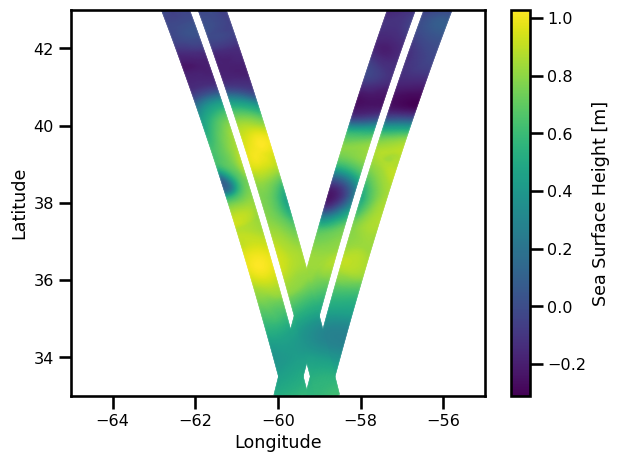

In [23]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_swot.sel(time=slice("2012-10-26","2012-10-26"))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
    ylim=[33., 43.]
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

## SWOT + NADIR

In [31]:
ds_nadir

<xarray.Dataset>
Dimensions:      (time: 42468, cycle: 1)
Coordinates:
    lon          (time) float64 -55.03 -55.06 -55.1 ... -64.89 -64.93 -64.97
    lat          (time) float64 39.58 39.53 39.47 39.42 ... 42.12 42.17 42.22
  * time         (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12...
Dimensions without coordinates: cycle
Data variables:
    x_al         (time) float32 1.008e+06 1.008e+06 ... 5.373e+06 5.373e+06
    ncycle       (time, cycle) timedelta64[ns] 17 days 09:34:50.917929600 ......
    model_index  (time) float32 515.0 515.0 515.0 ... 1.533e+03 1.533e+03
    ssh_obs      (time) float64 0.975 1.008 1.009 ... -0.0774 -0.0679 -0.0703
    ssh          (time) float64 0.9958 1.014 1.027 ... -0.0576 -0.0568 -0.051
    nadir_err    (time) float64 -0.0208 -0.0061 -0.0182 ... -0.0111 -0.0193
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [32]:
ds_swot

<xarray.Dataset>
Dimensions:      (time: 955000)
Coordinates:
    lon          (time) float64 -55.4 -55.37 -55.39 ... -64.45 -64.47 -64.5
    lat          (time) float64 42.99 42.99 42.97 42.97 ... 42.98 42.99 42.99
  * time         (time) datetime64[ns] 2012-10-23T18:04:12.393963 ... 2012-11...
Data variables: (12/13)
    x_al         (time) float32 1.001e+06 1.001e+06 ... 1.01e+07 1.01e+07
    x_ac         (time) float32 -60.0 -58.0 -60.0 -58.0 ... -60.0 -58.0 -56.0
    lon_nadir    (time) float64 305.3 305.3 305.3 305.3 ... 294.8 294.8 294.8
    lat_nadir    (time) float64 43.12 43.12 43.1 43.1 ... 43.1 43.12 43.12 43.12
    model_index  (time) float32 546.0 546.0 546.0 ... 1.446e+03 1.446e+03
    timing_err   (time) float64 0.00496 0.00496 0.004528 ... -0.03043 -0.03043
    ...           ...
    roll_err     (time) float64 -0.1154 -0.1116 -0.1102 ... 0.07341 0.07088
    phase_err    (time) float64 0.06866 0.06637 0.06041 ... 0.04271 0.04124
    ssh          (time) float64 -0.0096 -0.0116 -0.0083 ... -0.0444 -0.0518
    bd_err       (time) float64 0.009219 0.008615 ... -0.004289 -0.003999
    karin_err    (time) float64 -0.0198 0.0012 0.0096 ... 0.0122 -0.0247 -0.0235
    nC           (time) float64 0.0 1.0 0.0 1.0 2.0 3.0 ... 5.0 6.0 0.0 1.0 2.0
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        /data/MSA_ETU/mballarotta/ETUDE_BOOST-SWOT/out...
    title:                     SWOT-like data simulated by SWOT simulator
    keywords:                  SWOT, altimetry, SSH, satellite, remote sensing
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-11-27T16:45:37Z
    date_modified:             2018-11-27T16:45:37Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [ ]:
builtins

In [44]:
ds_swotnadir = xr.concat(
    [ds_nadir, ds_swot],
    # compat="override",
    # data_vars=["ssh"],
    # coords="minimal",
    dim="time", 
).sortby("time")

ValueError: 'ncycle' is not present in all datasets.

Now, let's combine the best of both worlds!

In [35]:
ds_swotnadir = xr.concat(
    [ds_nadir.drop("ncycle"), ds_swot],
    data_vars=["ssh"],
    coords="minimal",
    dim="time", 
).sortby("time")

ValueError: 'nadir_err' is not present in all datasets.

In [6]:
import xarray as xr

In [ ]:
xr.concat(

In [76]:
ds_swotnadir

<xarray.Dataset>
Dimensions:  (time: 997468)
Coordinates:
    lon      (time) float64 -55.03 -55.06 -55.1 -55.13 ... -64.89 -64.93 -64.97
    lat      (time) float64 39.58 39.53 39.47 39.42 ... 42.06 42.12 42.17 42.22
  * time     (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-03T...
Data variables:
    ssh      (time) float64 0.9958 1.014 1.027 1.032 ... -0.0576 -0.0568 -0.051
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

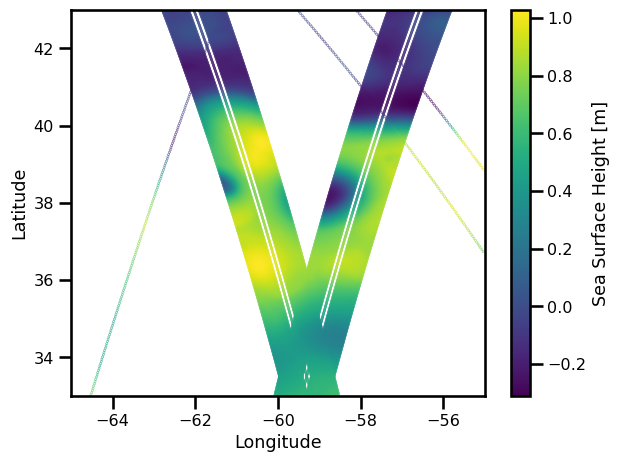

In [77]:
%matplotlib inline

fig, ax = plt.subplots()

sub_ds = ds_swotnadir.sel(time=slice("2012-10-26","2012-10-26"))
variable = "ssh"
pts = ax.scatter(sub_ds.lon, sub_ds.lat, c=sub_ds[variable], s=0.1)
ax.set(
    xlabel="Longitude",
    ylabel="Latitude",
    xlim=[-65., -55.],
    ylim=[33., 43.]
)

plt.colorbar(pts, label="Sea Surface Height [m]")
plt.tight_layout()
plt.show()

### Gridding

In [78]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/

NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.decoded.nc
NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sss_y2013.1y.nc
NATL60-CJM165_GULFSTREAM_sst_y2013.1y.nc


In [79]:
file_natl60 = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"


In [80]:
def preprocess_natl60(da):
    
    da = validate_latlon(da)
    da = validate_time(da)
    da = decode_cf_time(da, units="seconds since 2012-10-01")
    da = validate_ssh(da)
    
    return da

In [81]:
%%time

files_natl60 = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"

ds_natl60 = xr.open_mfdataset(
    files_natl60,
    decode_times=False,
    preprocess=preprocess_natl60,
    combine="nested",
    engine="netcdf4",
    concat_dim="time"
)

ds_natl60 = ds_natl60.sortby("time").compute()

ds_natl60

CPU times: user 36.5 ms, sys: 60.2 ms, total: 96.7 ms
Wall time: 96.8 ms


<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 0.5019 0.5019 0.5097 ... -0.135 -0.135

## Data Structure

In [85]:
from oceanbench._src.geoprocessing.gridding import coord_based_to_grid

In [86]:
%%time

ds_nadir_gridded = coord_based_to_grid(
    ds_nadir, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

CPU times: user 2.38 s, sys: 29.7 ms, total: 2.41 s
Wall time: 2.42 s


In [87]:
%%time

ds_swot_gridded = coord_based_to_grid(
    ds_swot, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

CPU times: user 4.25 s, sys: 20.8 ms, total: 4.27 s
Wall time: 4.29 s


In [88]:
%%time

ds_swotnadir_gridded = coord_based_to_grid(
    ds_swotnadir, 
    ds_natl60,
    data_vars=["ssh"], 
    t_res=pd.to_timedelta(12, unit="hour")
)

CPU times: user 4.36 s, sys: 30.9 ms, total: 4.39 s
Wall time: 4.41 s


In [ ]:
import holoviews as hv
hv.extension("matplotlib")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [ ]:
variable = "ssh" # "vort_r" # "ke" #  
cmap = "viridis" # "RdBu_r" # "YlGnBu_r" #
field_name = "NATL60"

ssh_ds = xr.Dataset({
    field_name: ds_natl60[variable],
    "NADIR": np.isfinite(ds_nadir_gridded[variable]),
    "SWOT": np.isfinite(ds_swot_gridded[variable]),
    "SWOTNADIR": np.isfinite(ds_swotnadir_gridded[variable]),
})


to_plot_ds = ssh_ds.transpose("time", "lat", "lon")#.isel(time=slice(25, 55, 1))

clim = (
    to_plot_ds[
        [field_name, "NADIR", "SWOT", "SWOTNADIR"]
    ].to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
)

images = hv.Layout([
    hv.Dataset(to_plot_ds)
    .to(hv.QuadMesh, ["lon", "lat"], v).relabel(v)
    .options(cmap=cmap, clim=clim)
    for v in to_plot_ds]
).cols(2).opts(sublabel_format="")

hv.output(images, holomap="gif", fps=2, dpi=125)
# hv.save(images, filename="dc20a_natl60", fmt="gif", fps=2, dpi=125)